# Brain decoding with MLP

This part of the `session` aims to make `participants` familiar with [Multilayer Peceptrons](https://en.wikipedia.org/wiki/Multilayer_perceptron) as one possible `decoding model` that can be applied to `brain data`. The objectives 📍 are:

- get to know the basics of `Multilayer Peceptrons`

    - `model` creation
    - `model` `training` 
    - `model` `testing`


## Multilayer Perceptron
```{figure} mlp_decoding/multilayer-perceptron.png
---
width: 800px
name: multilayer-perceptron-fig
---
A multilayer perceptron with 25 units on the input layer, a single hidden layer with 17 units, and an output layer with 9 units. Figure generated with the [NN-SVG](http://alexlenail.me/NN-SVG/index.html) tool by [Alexander Lenail]. The figure is shared under a [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.
```
We are going to train a `Multilayer Perceptron` (`MLP`) `classifier` for `brain decoding` on the [Haxby dataset](https://main-educational.github.io/brain_encoding_decoding/haxby_data.html). `MLP`s are one of the most basic architecture of [artificial neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network). As such, `MLP`s consist of `input` and `output` `layers` as well as `hidden layers` that process the `input` through a succession of `transformations` towards the `output layer` that performs the task at hand, e.g. a `classification` or `regression`. Like other `machine learning models` for `supervised learning`, an `MLP` initially goes through a `training phase`. During this `supervised phase`, the `network` is taught what to look for and what is the desired output via its `objective function`. This refers to, minimizing the `loss`, ie the deviation of `predictions` from the "ground truth", and thus increasing its performance.

`MLP`s were actually among the first `ANN`s to appear, specifically the [Mark I Peceptron](https://en.wikipedia.org/wiki/Perceptron) which you can see below.

```{figure} https://preview.redd.it/wgzps0pvcny91.jpg?width=640&crop=smart&auto=webp&s=0b2e56dc4eaa886ebd01ac0cd8e51fc4efdb1d01
---
width: 400px
name: markI-perceptron-fig
---
Frank Rosenblatt with a Mark I Perceptron computer in 1960.
```


In this tutorial, we are going to train the simplest `MLP` architecture featuring one `input layer`, one `output layer` and just one `hidden layer`.

## Theoretical motivation

The previous tutorial on [brain decoding with SVM](https://main-educational.github.io/brain_encoding_decoding/svm_decoding.html)
shows how to use a linear combination of brain features to train a predictor.

Let's take a moment to consider this: a 1-layer perceptron with a sigmoid activation function
models the relation between `X` (the input data) and `y` (the predicted data)
the same way a logistic regression would:
$\hat{y} = \sigma(X \beta + \beta_0)$

```{figure} mlp_decoding/logistic_regression.png
---
width: 200px
name: logistic-regression-fig
---
A fitted logistic regression function classifying two different classes. Courtesy of [Jérôme Dockès](https://jeromedockes.github.io/).
```

If one optimizes the parameters of this MLP to minimize a cross-entropy loss,
they're actually optimizing for the same objective function as in a classical logistic regression problem:
$\underset{\beta, \beta_0}{\min} \sum_k y_k \log(\hat{y_k}) + (1 - y_k) \log(1 - \hat{y_k})$

As a rule of thumb, one can consider that a 1-layer perceptron
(and therefore any last layer of a multi-layer perceptron)
works similarly to an SVC.

A big motivation for using multiple-layer perceptrons is that they can introduce non-linearities
in our data. When training such models, the hope is that the hidden layers of the model
will find meaningful non-linear combinations of the input features which help us solve
our decoding problem.

## Getting the data

We are going to work with the Haxby dataset {cite:p}`Haxby2001-vt` again. You can check the section {ref}`haxby-dataset` for more details on that `dataset`. Here we are going to quickly `download` and prepare it for `machine learning applications` with a set of `predictive variables`, the `brain time series` `X`, and a `dependent variable`, the respective `cognitive processes`/`function`/`percepts` `y`.

In [1]:
import os
import warnings
warnings.filterwarnings(action='once')

from nilearn import datasets
# We are fetching the data for subject 4
data_dir = os.path.join('..', 'data')
sub_no = 4
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]

# mask the data
from nilearn.input_data import NiftiMasker
mask_filename = haxby_dataset.mask_vt[0]
masker = NiftiMasker(mask_img=mask_filename, standardize=True, detrend=True)
X = masker.fit_transform(func_file)

# cognitive annotations
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
y = behavioral['labels']

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, DeprecationWarning)
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/nilearn/image/resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/joblib/memory.py:312: DeprecationWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


As an initial check, we'll have a look at the size of `X` and `y`:

In [2]:
categories = y.unique()
print(categories)
print(y.shape)
print(X.shape)

['rest' 'face' 'chair' 'scissors' 'shoe' 'scrambledpix' 'house' 'cat'
 'bottle']
(1452,)
(1452, 675)


So we have `1452` `time points`, with one `label` for the respective `stimulus percept` each, and for each `time point` we have `recordings` of `brain` activity obtained via  `fMRI` across `675 voxels` (within the `VT` `mask`). We can also see that the `stimulus percept`s span `9` different `categories`.

However, concerning our planned analyses, we need to convert our `categories` into a [one-hot encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [3]:
# creating instance of one-hot-encoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
enc = OneHotEncoder(handle_unknown='ignore')
y_onehot = enc.fit_transform(np.array(y).reshape(-1, 1))
# turn the sparse matrix into a pandas dataframe
y = pd.DataFrame(y_onehot.toarray())
display(y[:10])

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Training a model

As introduced in the prior `tutorials`, one of the most important aspects of `machine learning` is the split between `train` and `tests`. `MLP`s are no exception to that and thus we need to split our dataset accordingly. We will keep `20%` of the `time points` as `test`, and then set up a `10 fold cross validation` for `training/validation`.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)   

With that, we can already build our `MLP`. Here, we are going to use [Tensorflow](https://www.tensorflow.org/) and [Keras](https://keras.io/). As with every other `ANN`, we need to `import` the respective components, here, the `model` and `layer` `type`. In our case we will use a [`Sequential` `model`](https://keras.io/guides/sequential_model/) and [`Dense`](https://keras.io/api/layers/core_layers/dense/) `layers`.

In [5]:
from keras.models import Sequential
from keras.layers import Dense

2024-10-14 20:17:05.595262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 20:17:05.612940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 20:17:05.612967: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 20:17:05.624826: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-10-14 20:17:06.584337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


`````{admonition} A note regarding our MLP
:class: tip
Please note that the example `MLP` we are going to `create` and `train` here is rather simple as we want to enable its application on machines with rather limited computational resources (ie your laptops or binder). "Real-world" models are usually more complex and might also entail different `types` and `layers`.
`````

Initially, we need to create our, so far, `empty model`.

In [6]:
# number of unique conditions that we have
model_mlp = Sequential()

Next, we can add the `layers` to our `model`, starting with the `input layer`. Given this is a rather short introduction to the topic and does not focus on `ANN`s, we are going to set the `kernel initialization` and `activation function` to appropriate defaults (Please have a look at the [Introduction to deep learning session](https://main-educational.github.io/material.html#introduction-to-deep-learning-using-pytorch) for more information.).

In [7]:
model_mlp.add(Dense(50 , input_dim = 675, kernel_initializer="uniform", activation = 'relu'))

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


As noted above, we are using `Dense` `layers` and as you can see, we set the `input dimensions` to `675`. You might have already notices that this is the number of `voxels` we have `data` from. Setting the `input dimension` according to the `data dimensions` is rather important is referred to as the [semantic gap](https://en.wikipedia.org/wiki/Semantic_gap): the transformation of `actions` & `percepts` conducted/perceived by `human`s into `computational representations`. For example, pictures are "nothing" but a huge `array` for a computer and what will be submitted to the input layer of an `ANN` (note: this also holds true for basically any other type of `data`). Here, our `MLP` receives the extracted `brain activity patterns` as `input` which are already in the right `array` format thanks to `nilearn`. Thus, always carefully think about what your `input` `data` entails and how it is structured to then setup your `input layer` accordingly.

Next, we are going to add one `hidden layer`.

In [8]:
model_mlp.add(Dense(30, kernel_initializer="uniform", activation = 'relu'))

And because we are creating a very simple `MLP` with only three `layers`, we already add our `output layer`, using the `softmax` `activation function` given that we aim to `train` our `MLP` to `predict` the different `categories` that were perceived by the `participants` from their `brain activity patterns`.

In [9]:
model_mlp.add(Dense(len(categories), activation = 'softmax'))

To get a nice overview of our `ANN`, we can now use the `.summary()` `function`, which will provide us with the `model type`, `model parameters` and for each `layer`, the its `type`, `shape` and `parameters`.

In [10]:
model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           279 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,609 (139.10 KB)

 Trainable params: 35,609 (139.10 KB)

 Non-trainable params: 0 (0.00 B)

With that, we already created our `MLP` `architecture`, which is now ready to be `compiled`! Within this step, we will set the `optimizer`, `loss function` and `metric`, ie `components` that define how our `MLP` will `learn`.

In [11]:
model_mlp.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Now it's to `train` our `MLP`. Thus, we have to `fit` it to our `data`, specifically only the `training` `data`. Here, we are going to provide a few more `hyperparameters` that will define how our `MLP` is going to `learn`. This entails the `batch size`, the `epochs` and `split` of `validation sets`. We will assign the respective output to a variable so that we can investigate our `MLP`'s `learning process`.

In [12]:
history = model_mlp.fit(X_train, y_train, batch_size = 10,
                             epochs = 10, validation_split = 0.2)

Epoch 1/10


 1/93 ━━━━━━━━━━━━━━━━━━━━ 1:04 699ms/step - accuracy: 0.4000 - loss: 2.1205

 2/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4250 - loss: 2.1139    

 3/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4389 - loss: 2.1139

64/93 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.4249 - loss: 1.8731

67/93 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.4258 - loss: 1.8702

66/93 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.4256 - loss: 1.8702

65/93 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.4253 - loss: 1.8673

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4350 - loss: 1.7979 - val_accuracy: 0.4635 - val_loss: 1.4617


Epoch 2/10


 1/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4000 - loss: 1.3857

 2/93 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.4500 - loss: 1.2045

 5/93 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.5490 - loss: 1.2045

 3/93 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.5000 - loss: 1.2045

63/93 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.5655 - loss: 1.2086

65/93 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.5664 - loss: 1.2065

69/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5681 - loss: 1.2029  

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5781 - loss: 1.1898 - val_accuracy: 0.5880 - val_loss: 1.2285


Epoch 3/10


 3/93 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.6389 - loss: 0.9541

 5/93 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.6793 - loss: 0.9274

 4/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6828 - loss: 0.8889  

67/93 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.7447 - loss: 0.8257

72/93 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.7450 - loss: 0.8252

73/93 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.7452 - loss: 0.8252

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7466 - loss: 0.8206 - val_accuracy: 0.6481 - val_loss: 1.0641


Epoch 4/10


 1/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8000 - loss: 0.6585

 3/93 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.8556 - loss: 0.6415

 2/93 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.8500 - loss: 0.6415

 5/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8653 - loss: 0.6310  

 4/93 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.8667 - loss: 0.6415

65/93 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.8250 - loss: 0.6031

68/93 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.8251 - loss: 0.6018

72/93 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.8254 - loss: 0.5953

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8274 - loss: 0.5867 - val_accuracy: 0.6738 - val_loss: 0.9169


Epoch 5/10


 2/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.2749

 3/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9778 - loss: 0.3520

 4/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9708 - loss: 0.3954

71/93 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.8988 - loss: 0.4043

70/93 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.8989 - loss: 0.4043

72/93 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.8987 - loss: 0.4036

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8978 - loss: 0.3972 - val_accuracy: 0.7167 - val_loss: 0.8203


Epoch 6/10


 1/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9000 - loss: 0.2050

 2/93 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.9000 - loss: 0.2046

 3/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9000 - loss: 0.2046 

68/93 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.9431 - loss: 0.2297

71/93 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.9432 - loss: 0.2302

69/93 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.9431 - loss: 0.2299

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9434 - loss: 0.2328 - val_accuracy: 0.7124 - val_loss: 0.8914


Epoch 7/10


 2/93 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 1.0000 - loss: 0.1994

 6/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9837 - loss: 0.1994

 4/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.1994

 5/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9920 - loss: 0.1994

 8/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9795 - loss: 0.2086

65/93 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.9759 - loss: 0.1720

67/93 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.9760 - loss: 0.1708

68/93 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.9761 - loss: 0.1708

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9767 - loss: 0.1644 - val_accuracy: 0.7382 - val_loss: 0.8925


Epoch 8/10


 2/93 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 1.0000 - loss: 0.0707

 3/93 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 1.0000 - loss: 0.0747

 4/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0759  

69/93 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.9875 - loss: 0.1024

71/93 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.9874 - loss: 0.1024

73/93 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.9874 - loss: 0.1024

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9870 - loss: 0.1017 - val_accuracy: 0.7725 - val_loss: 0.7944


Epoch 9/10


 1/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0275

 3/93 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 1.0000 - loss: 0.0309

67/93 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9963 - loss: 0.0474

66/93 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.9962 - loss: 0.0474

69/93 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.9963 - loss: 0.0475

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9967 - loss: 0.0480 - val_accuracy: 0.7897 - val_loss: 0.8139


Epoch 10/10


 1/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0187

 2/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0228 

68/93 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.9985 - loss: 0.0308

72/93 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.9984 - loss: 0.0310

71/93 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.9984 - loss: 0.0310

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9981 - loss: 0.0317 - val_accuracy: 0.7983 - val_loss: 0.7881


This looks about and what we would expect the `learning process` to be: across `epochs`, the `loss` is decreasing and the `accuracy` is increasing.  

`````{admonition} A note regarding the learning process of our MLP
:class: tip
Comparable to its architecture, our `MLP`'s `learning process` is also not really what you would see on the "real world". Usually, `ANN`s are `trained` way more, for longer periods of times, more `epochs` and on more `data`. However, we keep it rather short as we want to enable its application on machines with rather limited computational resources (ie your laptops or binder).
`````

While this is already informative, we can also plot the `loss` and `accuracy` in the `training` and `validation` `sets` respectively. Let's start with the `loss`.

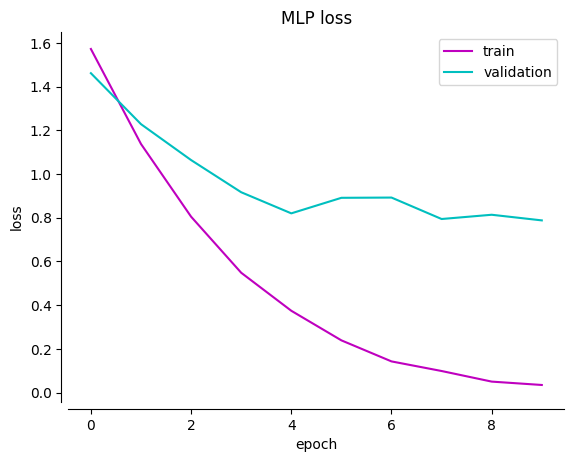

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'], color='m')
plt.plot(history.history['val_loss'], color='c')
plt.title('MLP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')

sns.despine(offset=5)

plt.show()

And now the same for the `accuracy`.

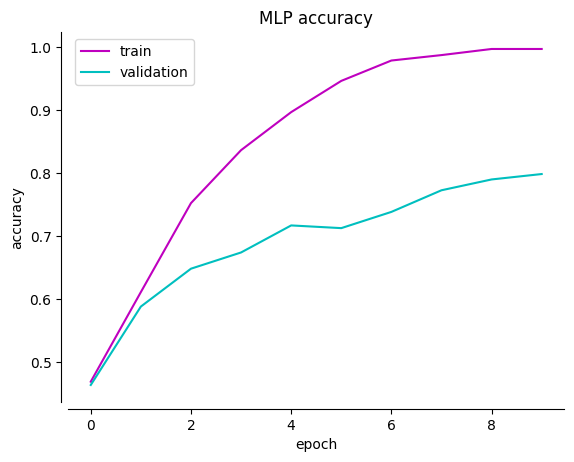

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['accuracy'], color='m')
plt.plot(history.history['val_accuracy'], color='c')
plt.title('MLP accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')

sns.despine(offset=5)

plt.show()

`````{admonition} How would you interpret these plots...
:class: tip
concerning our `MLP`'s `learning process`? Does it make sense? If not, how should it look like? Could you use these plots to evaluate certain aspects of the `learning process`, e.g. `regularization`?
`````

## Assessing performance

After evaluating the `training` of our `MLP`, we of course also need to evaluate its (`predictive`) `performance`. Here, this refers to the `accuracy` of our `MLP`'s outcomes, ie its `predictions`. We already saw this in the above plots and during the `training` across `epochs` but let's check the `accuracy` of the `prediction` on the `training set` again:

In [15]:
from sklearn.metrics import classification_report
y_train_pred = model_mlp.predict(X_train)
print(classification_report(y_train.values.argmax(axis = 1), y_train_pred.argmax(axis=1)))

 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


              precision    recall  f1-score   support

           0       0.90      0.93      0.91        85
           1       0.93      0.98      0.96        88
           2       0.96      0.88      0.92        90
           3       0.96      0.96      0.96        81
           4       0.99      0.97      0.98        91
           5       0.97      0.98      0.98       471
           6       0.92      0.94      0.93        81
           7       0.98      0.98      0.98        90
           8       0.95      0.93      0.94        84

    accuracy                           0.96      1161
   macro avg       0.95      0.95      0.95      1161
weighted avg       0.96      0.96      0.96      1161



Why you might think: "Oh, that's awesome, great performance.", such outcomes are usually perceived as dangerously high and indicate that something is off... 

`````{admonition} Why should a close-to-perfect performance indicate that something is wrong?
:class: tip
What do you think is the rationale to say that very high `scores` are actually "suspicious" and tells us that something is most likely wrong? Try thinking about the things you've learned so far: `training`/`test`/`validation` `datasets` and their size, `models`, `predictions`, etc. . 
`````


Luckily, we did `split` our `dataset` into **independent** `training` and `test` `sets`. So, let's check our `MLP`'s performance on the `test set`:

In [16]:
y_test_pred = model_mlp.predict(X_test)
print(classification_report(y_test.values.argmax(axis = 1), y_test_pred.argmax(axis=1)))

 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step


              precision    recall  f1-score   support

           0       0.64      0.78      0.71        23
           1       0.60      0.60      0.60        20
           2       0.72      0.72      0.72        18
           3       0.83      0.93      0.88        27
           4       0.88      0.88      0.88        17
           5       0.91      0.87      0.89       117
           6       0.62      0.56      0.59        27
           7       0.94      0.94      0.94        18
           8       0.71      0.71      0.71        24

    accuracy                           0.80       291
   macro avg       0.76      0.78      0.77       291
weighted avg       0.81      0.80      0.80       291



As you can see, the `scores`, ie `performance`, drops quite a bit. Do you know why and which you would report, e.g. in a `publication`?

Beside checking the overall `scores`, there are other options to further evaluate our `MLP`'s (or basically any other model's) `performance`. One of the most commonly used ones is called `confusion matrix` (which you most likely have seen before in this course). A `confusion matrix` displays how often a given `sample` was `predicted` as a certain `label`, thus, for example, providing insights into differentiability, etc. . To implement this, we initially have to compute the `confusion matrix`:

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix

cm_svm = confusion_matrix(y_test.values.argmax(axis = 1), y_test_pred.argmax(axis=1))
model_conf_matrix = cm_svm.astype('float') / cm_svm.sum(axis = 1)[:, np.newaxis]

After that, we can `plot` it for evaluation.

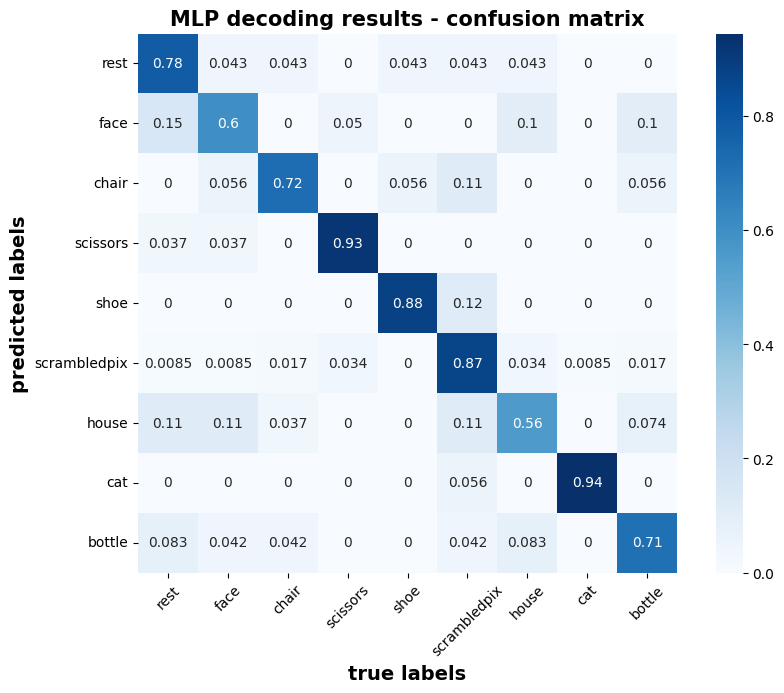

In [18]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(model_conf_matrix, index = categories,
                     columns = categories)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot = True, cmap = 'Blues', square = True)
plt.xticks(rotation = 45)
plt.title('MLP decoding results - confusion matrix' , fontsize = 15, fontweight = 'bold')
plt.xlabel("true labels", fontsize = 14, fontweight = 'bold')
plt.ylabel("predicted labels", fontsize = 14, fontweight = 'bold')
plt.show()

Based on this outcome: how would you interpret the `confusion matrix`? Are some `categories` better `"decodable"` than others? Could even make such a statement?

## Summary

With that, we already reached the end of this `tutorial` within which we talked about how to `create`, `train` and `evaluate` a `MLP` as one possible `decoding model` that can be applied to `brain data`. As mentioned before, the `MLP` utilized here is rather simple and `models` you see (and maybe use) out in the "real world" will most likely be way more complex. However, their application to `brain data` concerning `input`, `hidden` and `output layers` follows the same outline.

```{tip}
Unfortunately, visualizing the features/transformations of an `ANN` is quite often not straightforward as it depends on the given `ANN` architecture. However, you can check this fantastic 
[distill article](https://distill.pub/2017/feature-visualization/) to learn more about `feature visualization` in `artificial neural networks`.
```

## Exercises

 * What is the most difficult category to decode? Why?
 * The model seemed to overfit. Try adding a `Dropout` layer to regularize the model. You can read about dropout in keras in this [blog post](https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab).
 * Try to add layers or hidden units, and observe the impact on overfitting and training time.